# Pos Tagging

The purpose of pos tagging to get the potential aspect terms in each sentence. For sentences without aspects being detect will be directed to the sentence embedding extraction section.
The pos tagging model used here is from [Flair](https://github.com/flairNLP/flair), a library to perform NLP processing. This project revolves around using this library.

In [18]:
from datasets import load_from_disk
preprocessed_dataset = load_from_disk('data/preprocessed_data')

In [19]:
from unsupervised_absa.tagger import Tagger
tagger = Tagger('pos', device='cuda')
preprocessed_df = preprocessed_dataset.to_pandas()
preprocessed_df['pos_tag'] = tagger.tagging(preprocessed_df['text'], filter_tags=["NN", "NNS"])

2023-04-13 17:24:41,418 SequenceTagger predicts: Dictionary with 53 tags: <unk>, O, UH, ,, VBD, PRP, VB, PRP$, NN, RB, ., DT, JJ, VBP, VBG, IN, CD, NNS, NNP, WRB, VBZ, WDT, CC, TO, MD, VBN, WP, :, RP, EX, JJR, FW, XX, HYPH, POS, RBR, JJS, PDT, NNPS, RBS, AFX, WP$, -LRB-, -RRB-, ``, '', LS, $, SYM, ADD


2023-04-13 17:24:41.619 | INFO     | unsupervised_absa.tagger:__init__:32 - Tagger model instantiated with device: cpu
2023-04-13 17:24:41.648 | INFO     | unsupervised_absa.tagger:tagging:38 - Extracting pos tags
100%|██████████| 6055/6055 [35:48<00:00,  2.82it/s] 


In [25]:
# save postag results in a json file: list of dictionaries
import json
pos_tags = preprocessed_df.drop(columns=['aspectTerms', 'aspectCategories', 'domain']).to_dict('records')
with open("data/pos tag/semeval_pos_tag.json", "w") as fp:
    json.dump(pos_tags, fp) 

Performing these pos tags for nouns will give us the candidate terms. 

  0%|          | 0/6055 [00:00<?, ?it/s]

<Axes: title={'center': 'Top k Most Frequent Words'}>

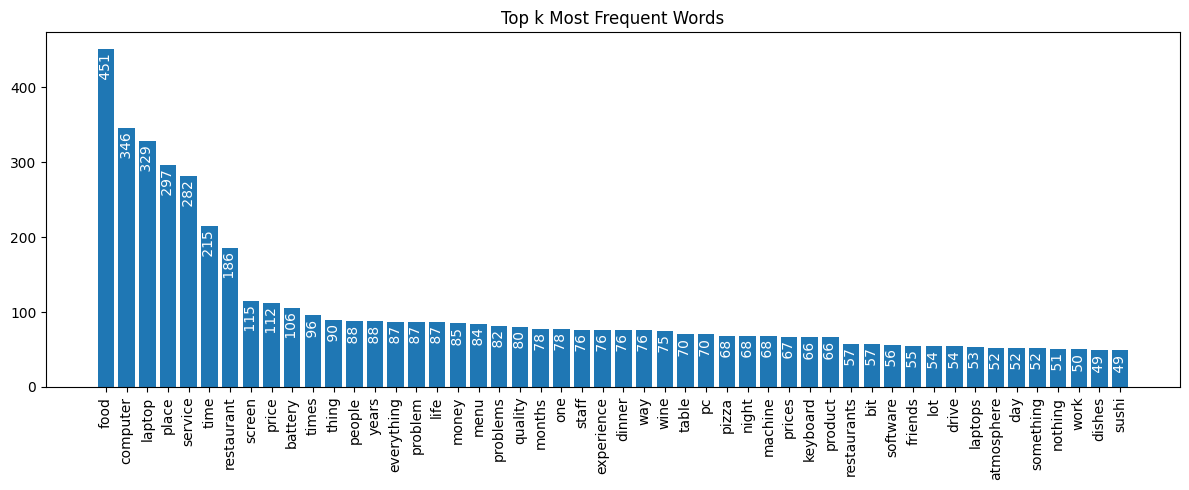

In [26]:
from tqdm.auto import tqdm
from unsupervised_absa.preprocess import plot_top_k_words
import json

with open('data/pos tag/semeval_pos_tag.json') as f:
    pos_tags = json.load(f)

list_of_words = []
for row in tqdm(pos_tags):
    for pos_data in row['pos_tag']:
        list_of_words.append(pos_data['word'])
plot_top_k_words(list_of_words, 50)

Remove words that has length less than 2

In [27]:
# filter tags with less than 3 letter
# save postag results in a json file: list of dictionaries
for row in tqdm(pos_tags):
    new_pos = []
    for pos_data in row['pos_tag']:
        if len(pos_data['word']) >= 3:
            new_pos.append(pos_data)
    row['pos_tag'] = new_pos

  0%|          | 0/6055 [00:00<?, ?it/s]

In [28]:
with open("data/pos tag/semeval_pos_tag_remove_short_words.json", "w") as fp:
    json.dump(pos_tags, fp)

Remove nouns that occured only once

In [29]:
from operator import itemgetter
import heapq
import collections
def least_common_values(array, to_find=None):
    counter = collections.Counter(array)
    if to_find is None:
        return sorted(counter.items(), key=itemgetter(1), reverse=False)
    return heapq.nsmallest(to_find, counter.items(), key=itemgetter(1))

In [30]:
from functools import reduce
array_nouns = list(map(lambda x: [tag['word'].lower() for tag in x['pos_tag']], pos_tags))
nouns = reduce(lambda x,y :x+y , array_nouns)

In [35]:
from collections import Counter
counter = Counter(nouns)
words_to_filter = []
for word, count in counter.items():
    if count == 1:
        words_to_filter.append(word)

In [38]:
for row in tqdm(pos_tags):
    pos_tag = []
    for pos_data in row['pos_tag']:
        if pos_data['word'] not in words_to_filter:
            pos_tag.append(pos_data)
    row['pos_tag'] = pos_tag

  0%|          | 0/6055 [00:00<?, ?it/s]

In [40]:
from functools import reduce
array_nouns = list(map(lambda x: [tag['word'].lower() for tag in x['pos_tag']], pos_tags))
nouns = reduce(lambda x,y :x+y , array_nouns)

In [44]:
with open("data/pos tag/semeval_pos_tag_remove_short_words_and_low_counts.json", "w") as fp:
    json.dump(pos_tags, fp)